### Homework Nr. 4
#### Tasks:
1. Complete week 2 of third course and week 1 of fourth course from specialization;
2. Complete the practical task.

#### Practical Task:
This week we will do something very different, instead of using a model-centric approach (meaning we have the
data fixed and we change the model and its hyperparameters) we will do a data-centric approach (meaning we have
the model fixed and we change the data and its preprocessing steps).
We have a similar to MNIST digits dataset, but with Roman numerals.

Your task is to:
1. Analyze the dataset
2. Clean the dataset, fix incorrect labels
3. Add your own data (your images, image augmentation, etc.).
    If you choose to create your own data, you may find this script helpful for converting your images: convert.py
4. Decide your train/val splits
5. Don't touch the test set, it's a fixed set for evaluation
6. Train and test the model (run train.py)
7. Iterate over this steps, and try to improve the results
8. Draw conclusions and see what are the differences

Good luck!

# Cleaning data

I will use widgets for displaying images, and select those that are bad and after this delete

In [2]:
import os
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image

In [3]:
import os
import ipywidgets as widgets
from IPython.display import display, clear_output

############################
# 0) Configuration
############################
ROOT_DIR = r"data\train"
CHUNK_SIZE = 12

# If you have a folder name where you last stopped, set it here:
START_FROM_FOLDER = "viii"  # Or None if you want to start from the beginning

############################
# 1) Gather images per folder
############################
def gather_images_by_folder_recursive(root_dir):
    valid_exts = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff'}
    folder_dict = {}
    
    for folder_name in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder_name)
        if os.path.isdir(folder_path):
            collected_paths = []
            for base, dirs, files in os.walk(folder_path):
                for file in files:
                    ext = os.path.splitext(file)[1].lower()
                    if ext in valid_exts:
                        full_path = os.path.join(base, file)
                        collected_paths.append(full_path)
            folder_dict[folder_name] = sorted(collected_paths)
    
    return folder_dict

def flatten_dict_to_list(folder_dict, start_from_folder=None):
    """
    Turn folder_dict into a list of (path, folder_name).
    If start_from_folder is given, skip all folders until we reach that folder_name,
    then take the remainder.
    """
    images_with_folders = []
    skip_mode = start_from_folder is not None
    found_start = False

    for folder_name, paths in folder_dict.items():
        # If we are in skip mode, keep skipping until we find our target folder.
        if skip_mode and (folder_name == start_from_folder):
            skip_mode = False
            found_start = True
        
        if not skip_mode:
            for p in paths:
                images_with_folders.append((p, folder_name))
    
    if start_from_folder is not None and not found_start:
        print(f"WARNING: start_from_folder '{start_from_folder}' not found in folder_dict. Starting from the first folder instead.")
    
    return images_with_folders

##########################
# 2) Chunks and UI helpers
##########################

def make_chunks(lst, chunk_size):
    for i in range(0, len(lst), chunk_size):
        yield lst[i : i + chunk_size]

def create_image_widget(path, max_width=200, max_height=200):
    with open(path, 'rb') as f:
        img_bytes = f.read()
    ext = os.path.splitext(path)[1].lower().lstrip('.')
    if ext == 'jpg':
        ext = 'jpeg'
    image_widget = widgets.Image(
        value=img_bytes,
        format=ext if ext in ['png','jpeg','gif','bmp','tiff'] else 'png',
        layout=widgets.Layout(max_width=f'{max_width}px', max_height=f'{max_height}px')
    )
    return image_widget

def create_item_widget(path, folder_name):
    label = widgets.Label(value=folder_name)
    img_widget = create_image_widget(path)
    checkbox = widgets.Checkbox(value=False, description='Bad?')
    vbox = widgets.VBox([label, img_widget, checkbox])
    return (vbox, checkbox, path, folder_name)

def build_chunk_widgets(images_with_folders):
    chunks = list(make_chunks(images_with_folders, CHUNK_SIZE))
    chunk_widgets_local = []
    for chunk in chunks:
        widget_list = []
        for (path, folder_name) in chunk:
            widget_list.append(create_item_widget(path, folder_name))
        chunk_widgets_local.append(widget_list)
    return chunk_widgets_local

##########################
# 3) Page management & buttons
##########################
chunk_widgets = []
current_chunk_idx = 0
image_display_box = widgets.VBox()

def update_page(page_idx):
    clear_output(wait=True)
    display(nav_box)
    
    if not chunk_widgets:
        print("No images in chunk_widgets.")
        return
    
    chunk_list = chunk_widgets[page_idx]
    row_widgets = []
    row = []
    MAX_PER_ROW = 4
    for i, (vbox, checkbox, path, folder_name) in enumerate(chunk_list):
        row.append(vbox)
        # finalize the row if we have 4 or we reach the end
        if (i + 1) % MAX_PER_ROW == 0 or (i + 1) == len(chunk_list):
            row_widgets.append(widgets.HBox(row))
            row = []
    image_display_box.children = tuple(row_widgets)
    display(image_display_box)

def on_prev_click(b):
    global current_chunk_idx
    if current_chunk_idx > 0:
        current_chunk_idx -= 1
    update_page(current_chunk_idx)

def on_next_click(b):
    global current_chunk_idx
    if current_chunk_idx < len(chunk_widgets) - 1:
        current_chunk_idx += 1
    update_page(current_chunk_idx)

def on_delete_click(b):
    global current_chunk_idx
    if not chunk_widgets:
        return
    current_items = chunk_widgets[current_chunk_idx]
    to_delete = []
    for (vbox, checkbox, path, folder_name) in current_items:
        if checkbox.value:
            try:
                os.remove(path)  # Real deletion
                to_delete.append(path)
            except Exception as e:
                print(f"Failed to delete {path}: {e}")
    
    # Filter out the deleted images from current chunk
    chunk_widgets[current_chunk_idx] = [
        (vbox, checkbox, path, folder_name) 
        for (vbox, checkbox, path, folder_name) in current_items
        if path not in to_delete
    ]
    
    print(f"Deleted {len(to_delete)} image(s).")
    update_page(current_chunk_idx)

prev_button = widgets.Button(description="< Previous", button_style='info')
next_button = widgets.Button(description="Next >", button_style='info')
delete_button = widgets.Button(description="Delete Bad", button_style='danger')

prev_button.on_click(on_prev_click)
next_button.on_click(on_next_click)
delete_button.on_click(on_delete_click)

nav_box = widgets.HBox([prev_button, next_button, delete_button])


In [4]:
##########################
# 4) Run the pipeline
##########################
folder_dict = gather_images_by_folder_recursive(ROOT_DIR)

# Flatten into a list, but skip all folders until START_FROM_FOLDER
images_with_folders = flatten_dict_to_list(folder_dict, start_from_folder=START_FROM_FOLDER)

chunk_widgets = build_chunk_widgets(images_with_folders)

# Display the navigation box
display(nav_box)

# Show the first page (if we have images)
if chunk_widgets:
    update_page(current_chunk_idx)
else:
    print("No images found.")


# Augumentation

In [6]:
import os
import cv2
import numpy as np
import random
from pathlib import Path

def random_rotate(image: np.ndarray,
                  min_angle: float,
                  max_angle: float) -> np.ndarray:
    """
    Randomly rotates the grayscale image by an angle between [min_angle, max_angle].
    Fills blank regions with white (255).
    """
    (height, width) = image.shape[:2] if image.ndim == 3 else image.shape
    angle = random.uniform(min_angle, max_angle)
    center = (width // 2, height // 2)
    
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(
        image, M, (width, height),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=255  # White for a single-channel (grayscale) image
    )
    return rotated_image

def random_perspective(image: np.ndarray,
                       min_shift: float,
                       max_shift: float) -> np.ndarray:
    """
    Applies a random perspective transform in grayscale. Each corner can shift by
    a value in [min_shift, max_shift] in both x and y directions.
    Fills blank regions with white (255).
    """
    (height, width) = image.shape[:2] if image.ndim == 3 else image.shape

    src_pts = np.float32([
        [0,      0],
        [width,  0],
        [width,  height],
        [0,      height]
    ])
    
    dst_pts = []
    for (x, y) in src_pts:
        shift_x = random.uniform(min_shift, max_shift)
        shift_y = random.uniform(min_shift, max_shift)
        dst_pts.append([x + shift_x, y + shift_y])
    
    dst_pts = np.float32(dst_pts)
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    
    warped_image = cv2.warpPerspective(
        image, M, (width, height),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=255  # White for a single-channel (grayscale) image
    )
    return warped_image

def generate_augmented_images(image: np.ndarray,
                              min_angle: float,
                              max_angle: float,
                              min_perspective_shift: float,
                              max_perspective_shift: float,
                              num_images: int = 5) -> list:
    """
    Given a grayscale image (np.ndarray), returns a list of 'num_images' augmented images.
    Each augmented image is generated by randomly applying BOTH:
      - rotation (angle in [min_angle, max_angle])
      - perspective shift in [min_perspective_shift, max_perspective_shift]
    """
    augmented_images = []
    for _ in range(num_images):
        # Random rotation
        rotated = random_rotate(image, min_angle, max_angle)
        # Random perspective transform
        warped = random_perspective(rotated, min_perspective_shift, max_perspective_shift)
        augmented_images.append(warped)
    return augmented_images

def augment_dataset(root_folder: str,
                    min_angle=-30, max_angle=30,
                    min_shift=-20, max_shift=20,
                    num_augmented=10):
    """
    Walks through root_folder (recursively), and for each image found,
    generates 'num_augmented' new images, saved in the same folder (grayscale).
    Naming convention:
        originalname_augment_1.ext, originalname_augment_2.ext, ...
    Supported image extensions can be changed as needed.
    """
    
    # Define which file extensions to consider images
    valid_extensions = {".png", ".jpg", ".jpeg", ".bmp", ".tiff"}
    
    for dirpath, dirnames, filenames in os.walk(root_folder):
        for filename in filenames:
            ext = os.path.splitext(filename)[1].lower()
            if ext in valid_extensions:
                # Construct the full path
                image_path = os.path.join(dirpath, filename)
                
                # Read the image in grayscale
                image_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if image_gray is None:
                    print(f"Warning: Could not read {image_path}")
                    continue
                
                # Generate augmented images (grayscale in, grayscale out)
                augmented_images = generate_augmented_images(
                    image=image_gray,
                    min_angle=min_angle,
                    max_angle=max_angle,
                    min_perspective_shift=min_shift,
                    max_perspective_shift=max_shift,
                    num_images=num_augmented
                )
                
                # Save each augmented image
                original_name, ext_ = os.path.splitext(filename)
                for i, aug_img_gray in enumerate(augmented_images, start=1):
                    # Example naming: originalName_augment_1.jpg
                    new_filename = f"{original_name}_augment_{i}{ext_}"
                    new_filepath = os.path.join(dirpath, new_filename)
                    
                    # Save as grayscale
                    cv2.imwrite(new_filepath, aug_img_gray)
                    
                print(f"Augmented {filename} -> created {num_augmented} new images.")


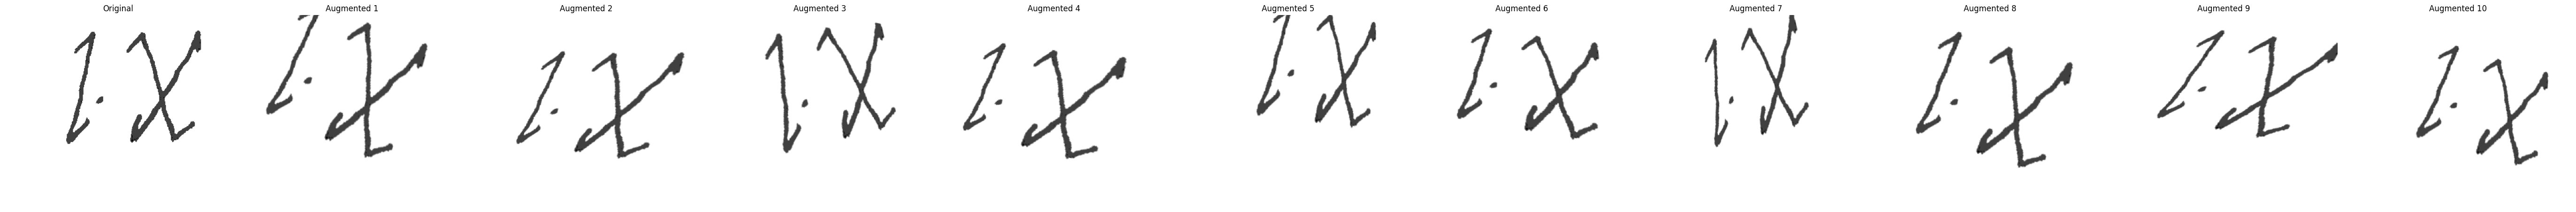

In [28]:
import cv2
import matplotlib.pyplot as plt


def display_images(original_image, augmented_images):
    """
    Displays the original image and all augmented images in a grid using matplotlib.
    """
    # We will show 1 + len(augmented_images) images in total
    total_images = 1 + len(augmented_images)

    fig, axes = plt.subplots(1, total_images, figsize=(5 * total_images, 5))

    # Convert from BGR to RGB if needed (depends on how you read your image)
    # If your original_image is already in RGB, skip the conversion
    # original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    original_image_rgb = original_image  # If already in RGB
    
    # Show the original image
    axes[0].imshow(original_image_rgb)
    axes[0].set_title("Original")
    axes[0].axis("off")

    # Show each augmented image
    for idx, aug_img in enumerate(augmented_images, start=1):
        axes[idx].imshow(aug_img)
        axes[idx].set_title(f"Augmented {idx}")
        axes[idx].axis("off")

    plt.tight_layout()
    plt.show()


# 1) Read an image (using OpenCV => BGR format)
image_path = r"D:\Projects\DeepLearning\L4\data\train\ix\ae8e1878-ce5d-11eb-b317-38f9d35ea60f.png"
image_bgr = cv2.imread(image_path)
if image_bgr is None:
    raise ValueError(f"Could not read image from path: {image_path}")

# Convert to RGB (for consistency with matplotlib)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# 2) Generate 5 augmented images
augmented_imgs = generate_augmented_images(
    image=image_rgb,
    min_angle=-20.0,      # Minimum rotation angle
    max_angle=20.0,       # Maximum rotation angle
    min_perspective_shift=-50.0,  # Min perspective shift
    max_perspective_shift=50.0,   # Max perspective shift
    num_images=10
)

# 3) Display
display_images(image_rgb, augmented_imgs)

In [29]:
folder_to_augment = r"D:\Projects\DeepLearning\L4\data\train"
augment_dataset(root_folder=folder_to_augment,
            min_angle=-30, max_angle=30,
            min_shift=-20, max_shift=20,
            num_augmented=10)

Augmented ab9fb784-ce5d-11eb-b317-38f9d35ea60f.png -> created 10 new images.
Augmented aba24486-ce5d-11eb-b317-38f9d35ea60f.png -> created 10 new images.
Augmented aba35128-ce5d-11eb-b317-38f9d35ea60f.png -> created 10 new images.
Augmented aba4001e-ce5d-11eb-b317-38f9d35ea60f.png -> created 10 new images.
Augmented aba4a622-ce5d-11eb-b317-38f9d35ea60f.png -> created 10 new images.
Augmented aba96072-ce5d-11eb-b317-38f9d35ea60f.png -> created 10 new images.
Augmented abaae12c-ce5d-11eb-b317-38f9d35ea60f.png -> created 10 new images.
Augmented abac5714-ce5d-11eb-b317-38f9d35ea60f.png -> created 10 new images.
Augmented abadf178-ce5d-11eb-b317-38f9d35ea60f.png -> created 10 new images.
Augmented abb1f8e0-ce5d-11eb-b317-38f9d35ea60f.png -> created 10 new images.
Augmented abb3aeb0-ce5d-11eb-b317-38f9d35ea60f.png -> created 10 new images.
Augmented abb4beb8-ce5d-11eb-b317-38f9d35ea60f.png -> created 10 new images.
Augmented abb5ba7a-ce5d-11eb-b317-38f9d35ea60f.png -> created 10 new images.

# Analyzing results after first iteration
test loss 0.35546261072158813, test acc 0.9153439402580261

Now, this is a good result, but let's  try another strategy:

1. Spotlighting images/classes where model makes mistakes, and trying to understand it's nature
2. Remove bad images from dev folder.
3. Remove some noise from images background   (Some images have spots/stains on the images, and we will try to remove them).
4. Remove augmented images, and try algorithm from above. And augument back images

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
base_model = tf.keras.applications.ResNet50(
    input_shape=(32, 32, 3),
    include_top=False,
    weights=None,
)

base_model = tf.keras.Model(
    base_model.inputs, outputs=[base_model.get_layer("conv2_block3_out").output]
)

inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.applications.resnet.preprocess_input(inputs)
x = base_model(x)
# x is a tuple/list if multiple outputs, so index 0
x = tf.keras.layers.GlobalAveragePooling2D()(x[0])
x = tf.keras.layers.Dense(10)(x)
model = tf.keras.Model(inputs, x)

# Compile (same as training)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# Load weights
model.load_weights("best_model.weights.h5")
print("Model loaded successfully with weights.")

Model loaded successfully with weights.


d:\Projects\DeepLearning\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [3]:
# 2) Build the test dataset

test_dir = "data/test"
class_names = ["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"]

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",  # yields one-hot labels
    class_names=class_names,
    shuffle=False,             # for consistent ordering
    batch_size=8,
    image_size=(32, 32),
)


Found 189 files belonging to 10 classes.


In [36]:
# 3) Get predictions and true labels
y_true = []
y_pred = []

# We'll collect all predictions in a list
for images, labels in test_dataset:
    # Predict
    preds = model.predict(images)
    # Convert from one-hot to integer class index
    predicted_indices = np.argmax(preds, axis=1)
    true_indices = np.argmax(labels.numpy(), axis=1)
    
    y_true.extend(true_indices)
    y_pred.extend(predicted_indices)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

d:\Projects\DeepLearning\.venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_184']
Received: inputs=Tensor(shape=(8, 32, 32, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


d:\Projects\DeepLearning\.venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_184']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


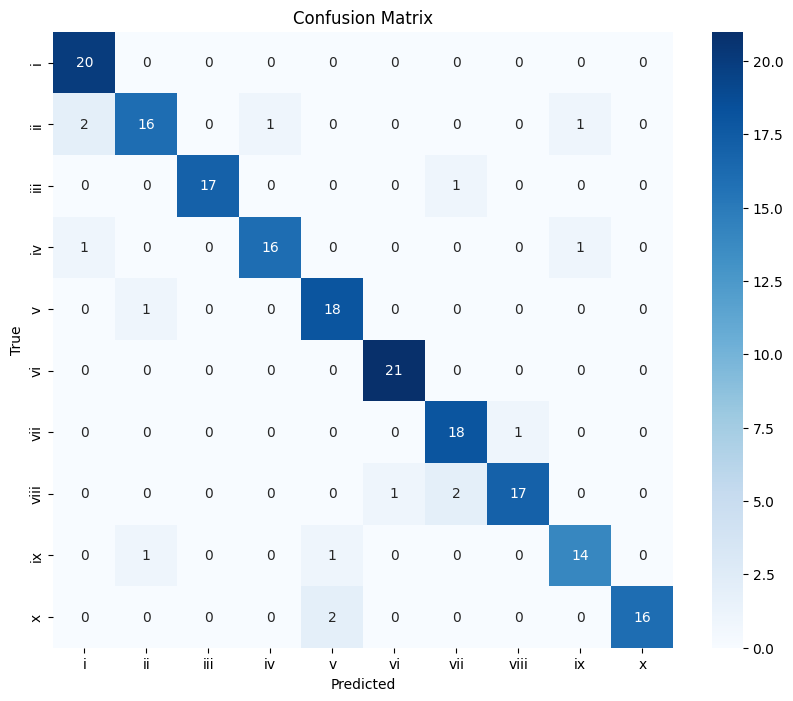

In [37]:
# 4) Construct and display confusion matrix

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


From the confusion matrix we have the following  conclusion:
1. Model needs more clear information what number 2 means (4 misstakes with others, and 2 mistakes being considerated)
2. X and V are confussed (it is expected, because as Human I cannot understand some of them, if they are x or v)
3. Numbers  7 and 8 are confussed because they share the same traits. And the difference is only one stick.

### Let's try clear  data from validation set

In [4]:
ROOT_DIR = r"data\val"
CHUNK_SIZE = 12

START_FROM_FOLDER = None  

In [5]:
##########################
# 4) Run the pipeline
##########################
folder_dict = gather_images_by_folder_recursive(ROOT_DIR)

# Flatten into a list, but skip all folders until START_FROM_FOLDER
images_with_folders = flatten_dict_to_list(folder_dict, start_from_folder=START_FROM_FOLDER)

chunk_widgets = build_chunk_widgets(images_with_folders)

# Display the navigation box
display(nav_box)

# Show the first page (if we have images)
if chunk_widgets:
    update_page(current_chunk_idx)
else:
    print("No images found.")


We cleared now validation set from bad data.  Now we will try to move some data from validation to test set, in order to teach test data specific features. Mostly we will try to focus on number 2, 7 and 8

I cleared validation data, and interchanged.  Now I will display those images that were wrongly considered being another, and try to understand why it happens.

In [4]:
# Test dataset setup
test_dir = "data/test"
class_names = ["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"]

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=class_names,
    shuffle=False,
    batch_size=8,
    image_size=(32, 32),
)

# Predict and collect wrongly classified images
y_true = []
y_pred = []
wrong_images = []
wrong_labels = []
wrong_preds = []

for images, labels in test_dataset:
    preds = model.predict(images)
    predicted_indices = np.argmax(preds, axis=1)
    true_indices = np.argmax(labels.numpy(), axis=1)

    for i in range(len(images)):
        if predicted_indices[i] != true_indices[i]:
            wrong_images.append(images[i].numpy().astype("uint8"))
            wrong_labels.append(true_indices[i])
            wrong_preds.append(predicted_indices[i])

Found 189 files belonging to 10 classes.


d:\Projects\DeepLearning\.venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(8, 32, 32, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


d:\Projects\DeepLearning\.venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


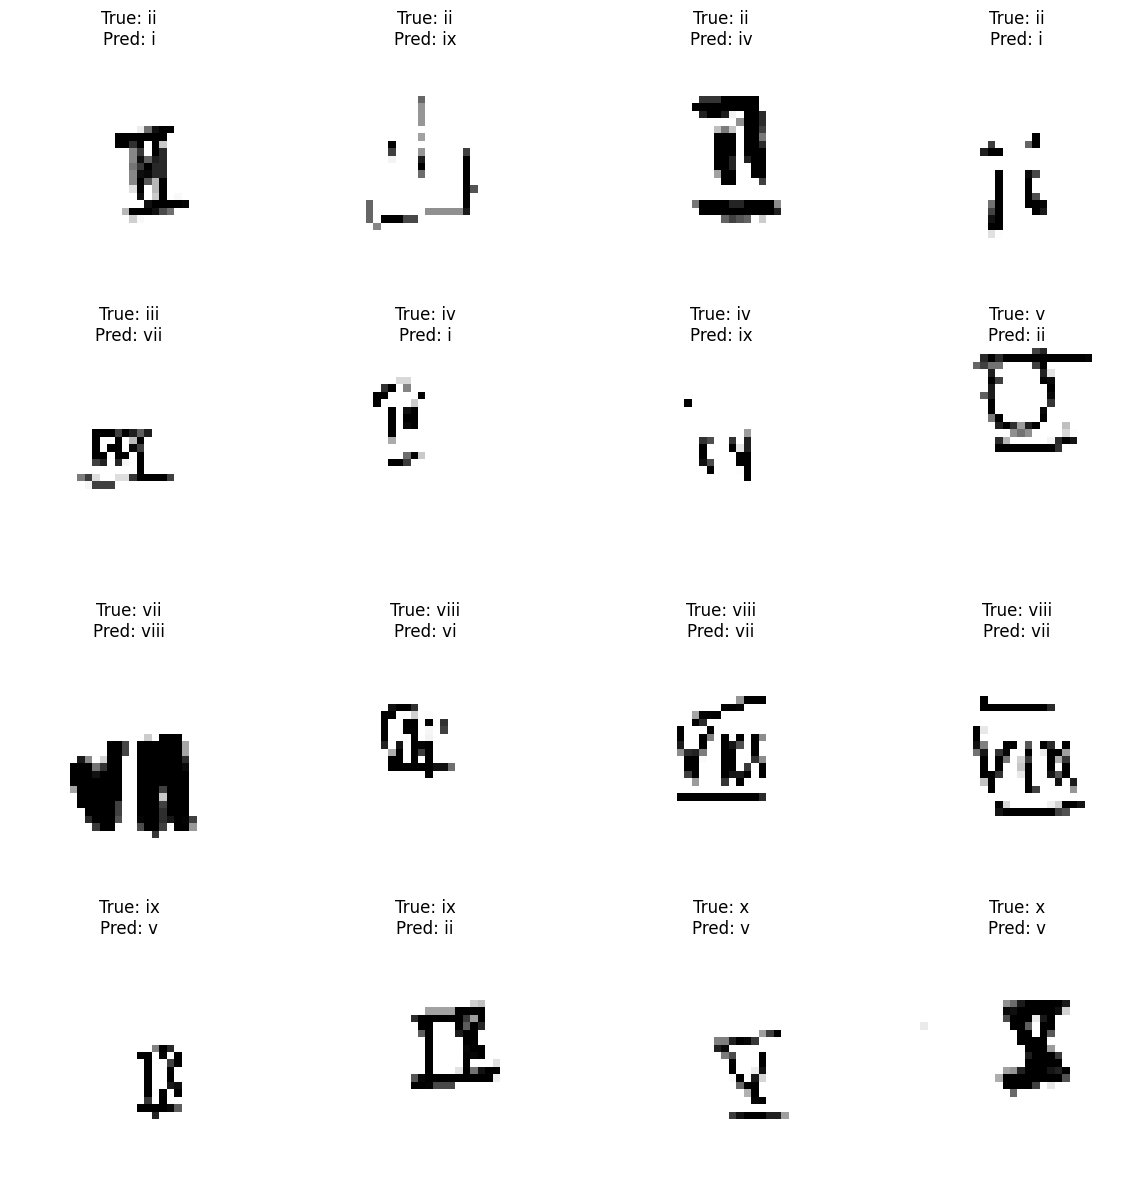

In [5]:
# Visualize wrongly classified images
def visualize_wrong_predictions(images, true_labels, predicted_labels, class_names):
    num_images = len(images)
    rows = (num_images // 4) + int(num_images % 4 != 0)
    fig, axes = plt.subplots(rows, 4, figsize=(12, rows * 3))
    axes = axes.flatten()

    for i in range(len(images)):
        ax = axes[i]
        ax.imshow(images[i])
        ax.axis("off")
        ax.set_title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[predicted_labels[i]]}")

    for j in range(len(images), len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

visualize_wrong_predictions(wrong_images, wrong_labels, wrong_preds, class_names)


From the above image, I can conclude that the "wrongly predicted data" is not entirely incorrect. Considering that the model cannot accurately predict cases where even humans struggle, I would say that the model's overall accuracy is good, despite the presence of some particularly challenging data in the test folder. Nevertheless, I plan to make another round of training with newly augmented data to observe if there are any improvements.

#  Augmentation and training the second iteration

In [7]:
folder_to_augment = r"D:\Projects\DeepLearning\L4\data\train"
augment_dataset(root_folder=folder_to_augment,
            min_angle=-30, max_angle=30,
            min_shift=-20, max_shift=20,
            num_augmented=10)

Augmented ab9fb784-ce5d-11eb-b317-38f9d35ea60f.png -> created 10 new images.
Augmented aba24486-ce5d-11eb-b317-38f9d35ea60f.png -> created 10 new images.
Augmented aba35128-ce5d-11eb-b317-38f9d35ea60f.png -> created 10 new images.
Augmented aba4001e-ce5d-11eb-b317-38f9d35ea60f.png -> created 10 new images.
Augmented aba4a622-ce5d-11eb-b317-38f9d35ea60f.png -> created 10 new images.
Augmented aba96072-ce5d-11eb-b317-38f9d35ea60f.png -> created 10 new images.
Augmented abaae12c-ce5d-11eb-b317-38f9d35ea60f.png -> created 10 new images.
Augmented abac5714-ce5d-11eb-b317-38f9d35ea60f.png -> created 10 new images.
Augmented abadf178-ce5d-11eb-b317-38f9d35ea60f.png -> created 10 new images.
Augmented abb1f8e0-ce5d-11eb-b317-38f9d35ea60f.png -> created 10 new images.
Augmented abb3aeb0-ce5d-11eb-b317-38f9d35ea60f.png -> created 10 new images.
Augmented abb4beb8-ce5d-11eb-b317-38f9d35ea60f.png -> created 10 new images.
Augmented abb5ba7a-ce5d-11eb-b317-38f9d35ea60f.png -> created 10 new images.